In [1]:
import concurrent.futures as cf
import math
import os
from pathlib import Path
import shutil
import sys
import uuid

import dask
import dask.dataframe as dd
import dask.array as da
import dask.diagnostics
from geo_transformers.models.any_horizon_forecast_transformer import AnyHorizonForecastTransformerCLI, SelectionHead
from geo_transformers import training_utils, notebook_utils
import IPython.display as ipd
import jsonargparse
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandarallel import pandarallel
import pyarrow.parquet as pq
import seaborn as sns
import torch
from torch.nn import functional as F
from tqdm.auto import tqdm
import wandb
import yaml

In [2]:
TMP_DIR = Path("/tmp/tmp.9YSt0bTTXY")

In [3]:
pandarallel.initialize(progress_bar=False)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Load metadata

In [4]:
individuals_df = pq.read_table("../data/movebank+ungulates/individuals.parquet").to_pandas().set_index("id")

In [5]:
seq_to_individual = (pq.read_table("../data/movebank+ungulates/locations_12h/", columns=["seq_id", "individual_id"])
 .to_pandas().drop_duplicates()
 .join(individuals_df, on="individual_id")
 .set_index("seq_id"))

## Load model and data

In [6]:
#ENTITY = "wandb-user"
PROJECT = "geo-transformers"
RUN_ID = "37ld98g9"

#run_path = f"{ENTITY}/{PROJECT}/{RUN_ID}"
run_dir = Path(f"../exp/forecast_mbk+ung_12h/{PROJECT}/{RUN_ID}")

[ckpt_path] = sorted((run_dir / "checkpoints").glob("*-best.ckpt"))
print(ckpt_path)

../exp/forecast_mbk+ung_12h/geo-transformers/37ld98g9/checkpoints/epoch=169-step=23629-best.ckpt


In [7]:
if (run_dir / "config.yaml").exists():
    f = open(run_dir / "config.yaml")
else:
    run_dir.mkdir(exist_ok=True)
    f = wandb.restore("config.yaml", run_path=run_path, root=run_dir)
with f:
    config_dict = yaml.load(f, Loader=yaml.SafeLoader)
config_dict = config_dict["fit"]["value"]
config_dict["trainer"]["logger"] = False

# do not split examples, keep full length; we extract our own slices later
for section in ["train", "val", "test"]:
    config_dict["data"][section]["split_max_len"] = None
    config_dict["data"][section]["encoded_max_len"] = None

del config_dict["seed_everything"], config_dict["ckpt_path"]

In [8]:
with notebook_utils.chdir(".."):
    config, objects = notebook_utils.load_experiment(AnyHorizonForecastTransformerCLI, config_dict)

    trainer = objects["trainer"]
    model = objects["model"]
    dmodule = objects["data"]
    dmodule.setup(stage="predict")
    processor = dmodule.processor
    
    dloader = dmodule.test_dataloader()
    
    dataset_raw = dmodule.test_dataloader().dataset
    dataset_raw.preprocess_fn = lambda x: x

In [9]:
model.load_state_dict(torch.load(ckpt_path)["state_dict"])

<All keys matched successfully>

In [10]:
model.cuda()
model.train(False)

AnyHorizonForecastTransformer(
  (encoder): AttentionLayers(
    (layers): ModuleList(
      (0): ModuleList(
        (0): ModuleList(
          (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (1): None
          (2): None
        )
        (1): Attention(
          (to_q): Linear(in_features=128, out_features=512, bias=False)
          (to_k): Linear(in_features=128, out_features=512, bias=False)
          (to_v): Linear(in_features=128, out_features=512, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
          (to_out): Linear(in_features=512, out_features=128, bias=True)
        )
        (2): Residual()
      )
      (1): ModuleList(
        (0): ModuleList(
          (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (1): None
          (2): None
        )
        (1): FeedForward(
          (net): Sequential(
            (0): Sequential(
              (0): Linear(in_features=128, out_features=512, bias=True)
              (1)

## Prepare data

In [11]:
def index_sequence(example, idx):
    return {k: v[idx] for k, v in example.items()}

In [12]:
def get_slices(example, max_ctx_len):
    n = sum(example["mask"])
    return [index_sequence(example, slice(i, i + max_ctx_len)) for i in range(n)]

In [13]:
def store_array(array):
    path = TMP_DIR / f"{uuid.uuid4().hex}.npy"
    array = np.asarray(array)
    np.save(path, array, allow_pickle=False)
    return da.from_delayed(dask.delayed(np.load)(path), shape=array.shape, dtype=array.dtype)

In [14]:
n_examples = len(dataset_raw)
dloader.dataset.num_candidates = 16
log_n = np.log(dloader.dataset.num_candidates)

example_ids = np.random.default_rng(0).choice(len(dataset_raw), n_examples, replace=False)
example_ids.sort()

with cf.ThreadPoolExecutor(16) as pool:
    examples_raw = list(tqdm(pool.map(dataset_raw.__getitem__, example_ids), total=n_examples))

  0%|          | 0/133 [00:00<?, ?it/s]

In [15]:
lengths = [len(ex["timestamp"]) for ex in examples_raw]
(np.array(lengths) >= 200).mean()

0.5864661654135338

## Get predictions

In [16]:
max_len = None
max_ctx_len = 200

shutil.rmtree(TMP_DIR, ignore_errors=True)
TMP_DIR.mkdir(parents=True)

preds_all = []

with torch.inference_mode():
    for i, example_raw in enumerate(tqdm(examples_raw)):
        example = processor.encode(example_raw)
        example = index_sequence(example, slice(0, max_len))
        slices = get_slices(example, max_ctx_len)
        loader = torch.utils.data.DataLoader(
            slices, batch_size=50,
            collate_fn=training_utils.collate_sequence_dicts
        )
        
        preds = torch.full((len(example["mask"]), max_ctx_len, dloader.dataset.num_candidates), torch.nan, dtype=torch.float32)

        # Run the model to fill in the predictions for all the context lengths
        j = 0
        for batch in tqdm(loader, leave=False):
            batch = dmodule.transfer_batch_to_device(batch, device=model.device, dataloader_idx=0)
            pred, _, _ = model(batch)

            pred = pred.log_softmax(dim=-1)
            pred.masked_fill_(~batch.get("loss_mask", batch["mask"]).unsqueeze(-1), np.nan)

            for jj in range(pred.shape[0]):
                pred_j = pred[jj][:batch["mask"][jj].sum()]
                preds[torch.arange(j, j + len(pred_j)), torch.arange(len(pred_j))] = pred_j.cpu()
                j += 1

        # Copy values for contexts longer than is available
        mask = torch.ones(preds.shape[:2], dtype=torch.bool).triu(1)
        diag = preds[np.minimum(torch.arange(preds.shape[1]), preds.shape[0] - 1), torch.arange(preds.shape[1])]
        diag = diag[:mask.shape[0]]
        assert torch.isnan(preds[mask]).all()
        preds.masked_scatter_(mask[..., None], diag[:, None].expand(diag.shape[0], *preds.shape[1:])[mask[:diag.shape[0]]])

        preds_all.append(store_array(preds))

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

## Define metrics

In [17]:
def compute_metrics(preds, example_raw):
    preds = torch.as_tensor(preds)
    tgt_one_hot = F.one_hot(torch.zeros(preds.shape[:-1], dtype=int), num_classes=preds.shape[-1])
    ent = (-preds * preds.exp()).sum(dim=-1) / log_n
    xent = F.kl_div(preds, tgt_one_hot, log_target=False, reduction="none").sum(dim=-1) / log_n
    kl_div_max = F.kl_div(preds, preds[:, [-1]], log_target=True, reduction="none").sum(dim=-1)
    kl_div_min = F.kl_div(preds, preds[:, [0]], log_target=True, reduction="none").sum(dim=-1)
    acc = (preds.argmax(dim=-1) == 0).to(float)

    return pd.DataFrame(
        {
            "seq_id": np.full(xent.shape, example_raw["seq_id"][0]).reshape(-1),
            "ent": ent.reshape(-1),
            "xent": xent.reshape(-1),
            "kl_div_max": kl_div_max.reshape(-1),
            "kl_div_min": kl_div_min.reshape(-1),
            "acc": acc.reshape(-1)
        },
        index=pd.MultiIndex.from_product(
            [range(xent.shape[0]), range(1, xent.shape[1] + 1)],
            names=["index", "ctx_len"]
        )
    ).reset_index()

metrics_df = dd.from_delayed(dask.delayed(compute_metrics)(preds, example_raw) for preds, example_raw in zip(preds_all, examples_raw))
with dask.diagnostics.ProgressBar():
    assert not metrics_df.isna().any().any().compute()

[########################################] | 100% Completed | 10.04 ss


### Save/load metrics

The computed metrics are available from: (TODO: add URL)

In [30]:
with dask.diagnostics.ProgressBar():
    metrics_df.to_parquet("mbk+ung_12h_cent_metrics/")

[########################################] | 100% Completed | 6.02 ss


In [31]:
metrics_df = dd.read_parquet("mbk+ung_12h_cent_metrics/")

## Draw plots

In [18]:
Path("figs/").mkdir(exist_ok=True)

[########################################] | 100% Completed | 16.81 ss


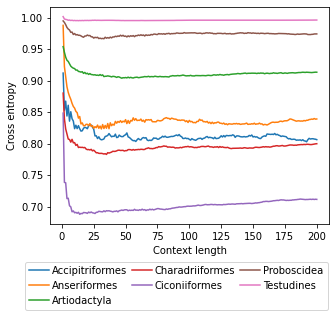

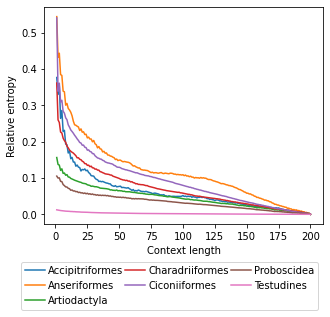

In [19]:
with dask.diagnostics.ProgressBar():
    df = metrics_df.query("index >= 200").join(seq_to_individual, on="seq_id")[["ctx_len", "xent", "kl_div_max", "taxon_order"]].reset_index().groupby(["ctx_len", "taxon_order"]).mean().sort_values(by="taxon_order").compute()

g = sns.lineplot(
    data=df,
    x="ctx_len", y="xent", hue="taxon_order", ci=None)
plt.xlabel("Context length")
plt.ylabel("Cross entropy")
plt.gcf().set_size_inches(5, 4)
g.legend(loc="upper center", bbox_to_anchor=(0.45, -0.15), ncol=3, columnspacing=0.5, handletextpad=0.3)
plt.savefig("figs/ctx_xent_order.pdf", bbox_inches="tight")
plt.show()

g = sns.lineplot(
    data=df,
    x="ctx_len", y="kl_div_max", hue="taxon_order", ci=None)
plt.xlabel("Context length")
plt.ylabel("Relative entropy")
plt.gcf().set_size_inches(5, 4)
g.legend(loc="upper center", bbox_to_anchor=(0.45, -0.15), ncol=3, columnspacing=0.2, handletextpad=0.3)
plt.savefig("figs/ctx_kl_div_max_order.pdf", bbox_inches="tight")
plt.show()

In [20]:
def compute_relevant_ctx_len(df, col):
    df = df.sort_values(by="ctx_len")
    c_idx = df.index[df.eval(f"({col} - {col}.min()) / ({col}.max() - {col}.min()) <= 0.05")][0]
    return df.loc[[c_idx]]

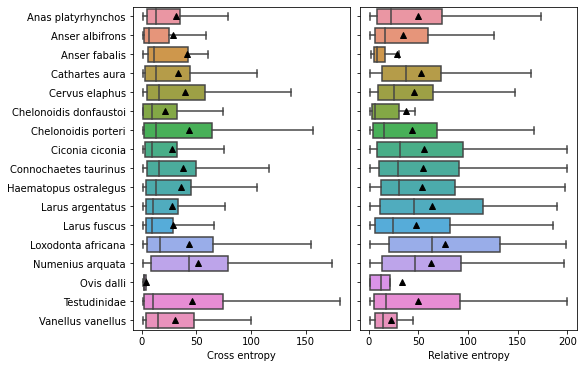

In [21]:
fig, axes = plt.subplots(1, 2, sharey=True, constrained_layout=True)

for metric, xlabel, ax in zip(["xent", "kl_div_max"], ["Cross entropy", "Relative entropy"], axes):
    df = metrics_df.query("index >= 200").compute()
    df = df.groupby(["seq_id", "index"]).parallel_apply(compute_relevant_ctx_len, col=metric).reset_index(drop=True)
    df = df.join(seq_to_individual[["taxon_canonicalName"]], on="seq_id")
    df = df.sort_values(by="taxon_canonicalName")
    sns.boxplot(data=df, y="taxon_canonicalName", x="ctx_len",
                showmeans=True, meanprops=dict(markerfacecolor="black", markeredgecolor="black"),
                showfliers=False, ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(None)

plt.gcf().set_size_inches(8, 5)
plt.savefig("figs/c_boxplot.pdf", bbox_inches="tight")
plt.show()

,individual_id,taxon,taxon_canonicalName,taxon_vernacularName,taxon_rank,taxon_kingdom,taxon_phylum,taxon_class,taxon_order,taxon_family,taxon_genus,taxon_species
seq_id,,,,,,,,,,,,
1200772538_0,1200771388,Cervus elaphus,Cervus elaphus,Red Deer (see comments),SPECIES,Animalia,Chordata,Mammalia,Artiodactyla,Cervidae,Cervus,Cervus elaphus
1133104476_0,1133104458,Larus argentatus,Larus argentatus,European Herring Gull,SPECIES,Animalia,Chordata,Aves,Charadriiformes,Laridae,Larus,Larus argentatus
29852247_1,29852238,Ciconia ciconia,Ciconia ciconia,White Stork,SPECIES,Animalia,Chordata,Aves,Ciconiiformes,Ciconiidae,Ciconia,Ciconia ciconia


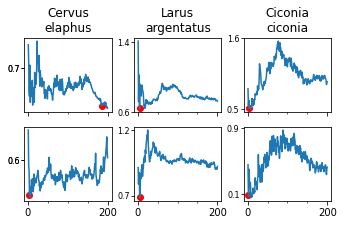

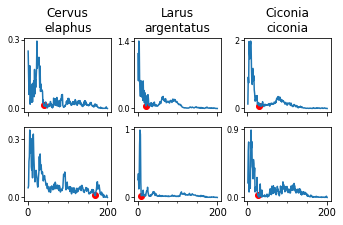

In [22]:
seq_ids_long = sorted(metrics_df.query("index >= 200")["seq_id"].unique().compute())
seq_ids_sample = np.random.default_rng(2).choice(seq_ids_long, 3, replace=False)
ipd.display(seq_to_individual.loc[seq_ids_sample])

for metric in ["xent", "kl_div_max"]:
    fig, axes = plt.subplots(2, len(seq_ids_sample), figsize=(5.5, 3), sharex=True, gridspec_kw=dict(wspace=0.26))
    rng = np.random.default_rng(0)
    for ax_col, seq_id in zip(axes.T, seq_ids_sample):
        ax_col[0].set_title(seq_to_individual.loc[seq_id, "taxon_canonicalName"].replace(" ", "\n"))
        seq_df = metrics_df.query(f"seq_id == @seq_id", local_dict=dict(seq_id=seq_id)).compute()
        for ax, idx in zip(ax_col, rng.choice(sorted(seq_df.query("index >= 200")["index"].unique()), axes.shape[0], replace=False)):
            df = seq_df.query("index == @idx").sort_values(by="ctx_len")
            ax.plot(df["ctx_len"], df[metric])
            c_idx = df.index[df.eval(f"({metric} - {metric}.min()) / ({metric}.max() - {metric}.min()) <= 0.05")][0]
            ax.scatter(df.loc[c_idx, "ctx_len"], df.loc[c_idx, metric], color="red")
            ymin, ymax = ax.get_ylim()
            ax.set_yticks([np.round(ymin + 0.05, decimals=1), np.round(ymax - 0.05, decimals=1)])
            ax.tick_params(axis="y", labelsize=8, pad=1)
            ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
    plt.savefig(f"figs/ctx_{metric}_examples.pdf", bbox_inches="tight")
    plt.show()